In [29]:
import os
import numpy as np
import nibabel as nib
import dicom2nifti
import pickle
from totalsegmentator.python_api import totalsegmentator
from loguru import logger
import sys
import resampling
from itkwidgets import view

In [31]:
with open("processing/excluded_cts.pkl","rb") as f:
    excluded_cts = pickle.load(f)

In [32]:
print(excluded_cts)

[43, 93, 96, 102, 129, 161, 162, 199, 223, 224, 237, 243, 260, 273, 286, 291, 301, 302, 303, 306, 311, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 360, 364, 396, 398, 446, 487, 495, 498, 521, 541, 550, 554, 556, 567, 577, 585, 588, 614, 615, 627, 631, 634, 635, 637, 641, 652, 667, 672, 673, 678, 680, 681, 780, 832, 865, 882, 905, 906, 913, 961, 990, 994, 1017, 1050, 1056, 1078, 1080, 1081, 1082, 1131, 1139, 1142, 1145, 1160, 1173, 1174, 1198, 1200, 1232, 1243, 1249, 112, 304, 319, 340, 358, 483, 872, 903, 946, 1045, 1151, 1192, 552]


# Resampling

In [16]:
# Meglio dividere resampling e segmentazione
ct_number = 339
nifti_img = nib.load(f"processing/{ct_number}/shoulder_nifti.nii")
nifti_img_res = resampling.change_spacing(nifti_img,new_spacing=(1,1,1),order=1)
nib.save(nifti_img_res,f"processing/{ct_number}/shoulder_nifti_res.nii")


If you use this tool please cite: https://pubs.rsna.org/doi/10.1148/ryai.230024

Generating rough body segmentation...
Resampling...
  Resampled in 0.78s
Predicting...
  Predicted in 4.96s
Resampling...
  cropping from (250, 250, 120) to (186, 180, 120)
Resampling...
  Resampled in 0.49s
Predicting part 1 of 1 ...
  Predicted in 6.24s
Resampling...
Saving segmentations...
  Saved in 0.68s


In [ ]:
shoulder_seg_res = totalsegmentator(f"processing/{ct_number}/shoulder_nifti_res.nii",f'processing/{ct_number}/shoulder_seg_res.nii',ml=True,output_type="nifti",quiet=False,roi_subset=["humerus_left","humerus_right","scapula_left","scapula_right"])

In [53]:
def shoulder_resampling(spacing=(0.5,0.5,0.5),int_order=2):
    """
    Effettua il resampling di tutte le spalle in modo da ottenere immagini isotropiche
    """
    for i in range(40,50):
        if i not in excluded_cts:
            try:
                if os.path.exists(f"processing/{i}/shoulder_nifti.nii"):
                    nifti_img = nib.load(f"processing/{i}/shoulder_nifti.nii")
                    nifti_img_res = resampling.change_spacing(nifti_img,new_spacing=spacing,order=int_order,dtype="<i2")
                    nib.save(nifti_img_res,f"processing/{i}/shoulder_nifti_res.nii") 
                    logger.info(f"Resampling spalla {i} eseguito")
                else:
                    logger.info(f"Spalla {i} non esistente")
            except:
                logger.warning(f"Eccezione spalla {i}")
        else:
            logger.info(f"Spalla {i} esclusa")

In [54]:
logger.remove()
logger.add(sys.stdout, format="{message}", level="WARNING")
logger.add("segmentation/resampling_log.log", format="{time:DD-MM HH:mm:ss} - {message}", level="INFO")

shoulder_resampling()

In [58]:
nib.load("processing/4/shoulder_nifti.nii").header.get_zooms(),nib.load("processing/1/shoulder_nifti.nii").dataobj.dtype,nib.load("processing/1/shoulder_nifti.nii").shape

((0.585938, 0.585938, 0.625), dtype('<i2'), (512, 512, 185))

In [57]:
nib.load("processing/4/shoulder_nifti_res.nii").header.get_zooms(),nib.load("processing/1/shoulder_nifti_res.nii").dataobj.dtype,nib.load("processing/1/shoulder_nifti_res.nii").dataobj.shape

((0.5, 0.5, 0.5), dtype('<i2'), (600, 600, 370))

In [59]:
for i in range(1,1251):
    if os.path.exists(f"processing/{i}/shoulder_nifti_res.nii"):
        zoom = nib.load(f"processing/{i}/shoulder_nifti_res.nii").header.get_zooms()
        if zoom[0] != 0.5:
            print(zoom)

FileNotFoundError: No such file or no access: 'processing/2/shoulder_nifti_res.nii'

# Segm

In [28]:
def shoulder_segmentation_resampled():
    """
    Segmentazione spalle isotropiche ottenute tramite resampling
    """
    for i in range(1,1251):
        try:
            if os.path.exists(f"processing/{i}/shoulder_nifti_res.nii"):
                totalsegmentator(f"processing/{i}/shoulder_nifti_res.nii",f'processing/{i}/shoulder_seg_res.nii',ml=True,output_type="nifti",quiet=True,roi_subset=["humerus_left","humerus_right","scapula_left","scapula_right"])
                logger.info(f"Segmentazione spalla {i} eseguita")
            else:
                logger.info(f"Spalla {i} non esistente")
        except:
            logger.warning(f"Eccezione spalla {i}")

In [18]:
logger.remove()
logger.add(sys.stdout, format="{message}", level="WARNING")
logger.add("segmentation/segmentations_res_log.log", format="{time:DD-MM HH:mm:ss} - {message}", level="INFO")

shoulder_segmentation_resampled()

Predicting part 1 of 1 ...
Predicting part 1 of 1 ...


In [25]:
nib.load("processing/4/shoulder_seg_res.nii").header.get_zooms()

(1.0, 1.0, 1.0)

In [21]:
data = np.asarray(nib.load("processing/4/shoulder_seg.nii").dataobj)


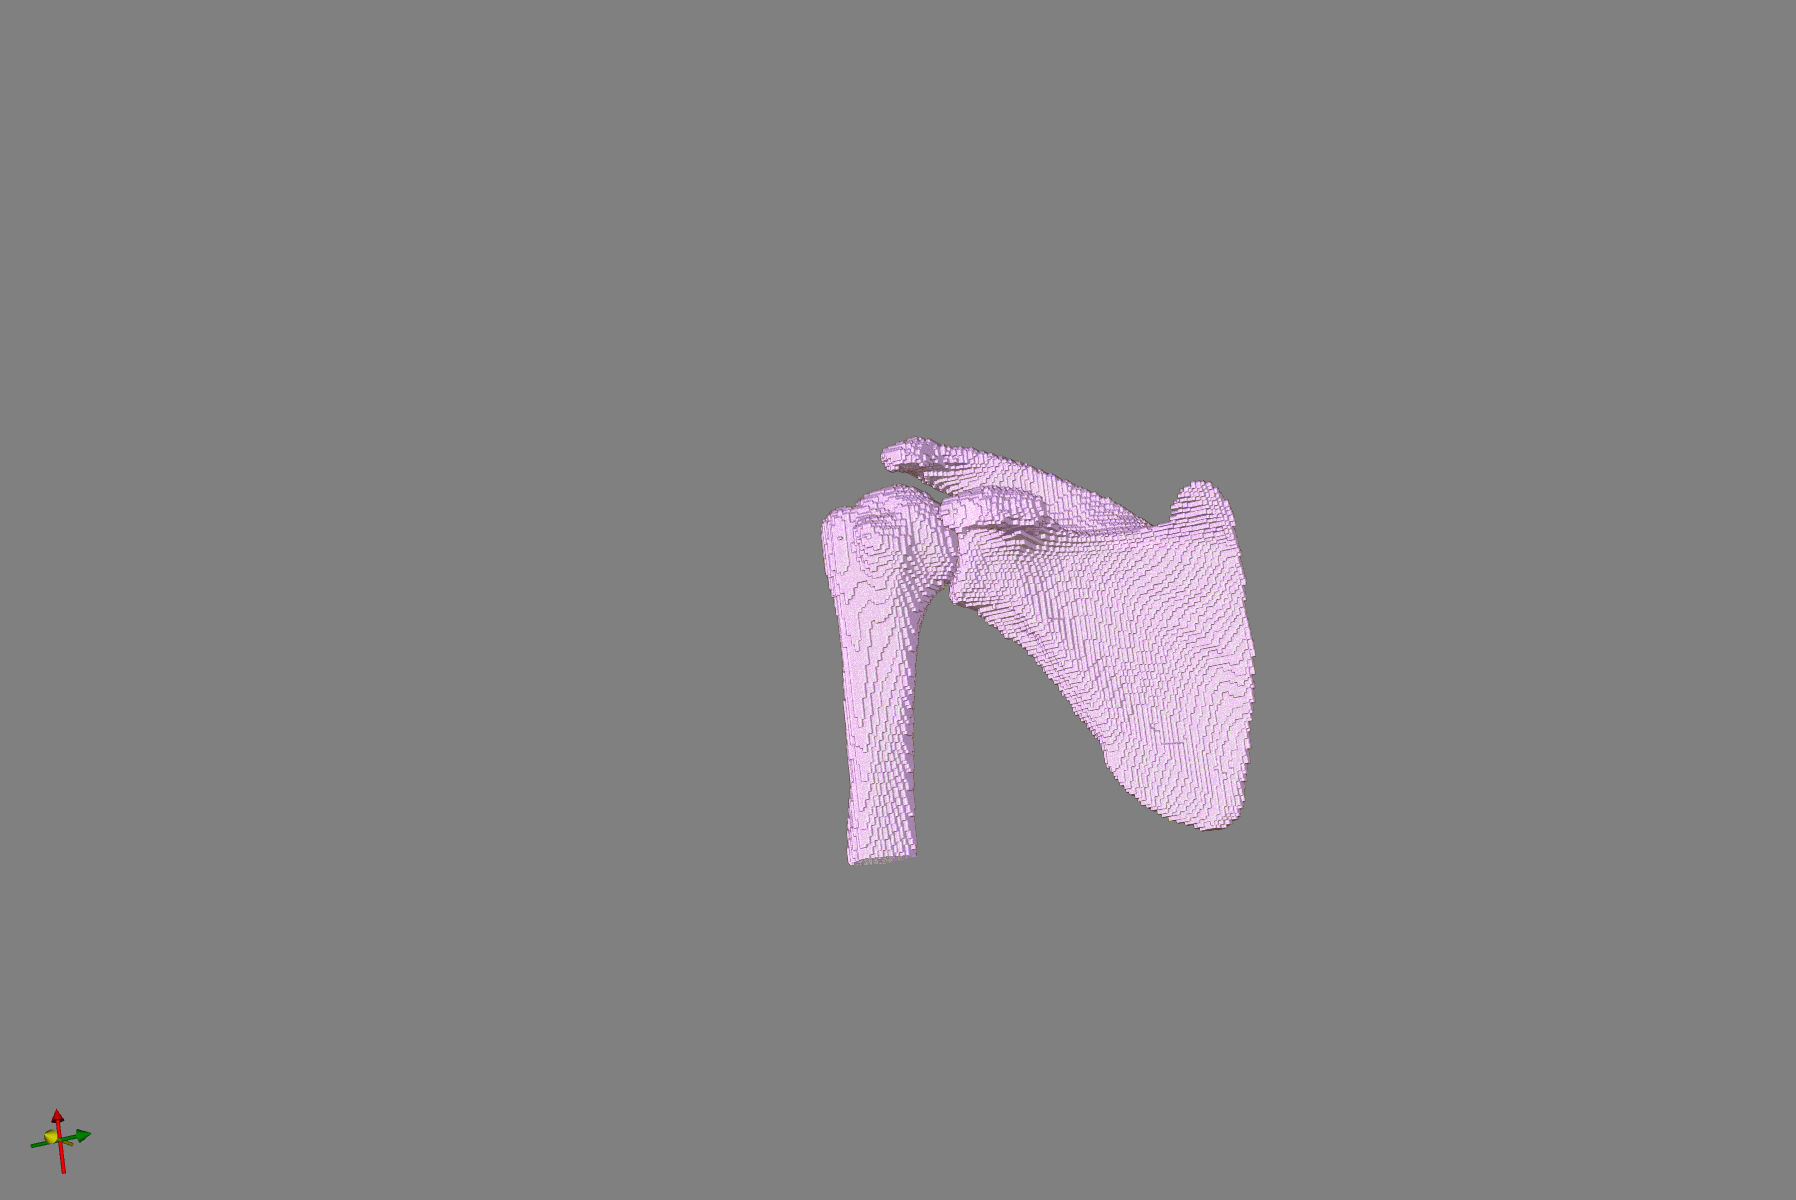
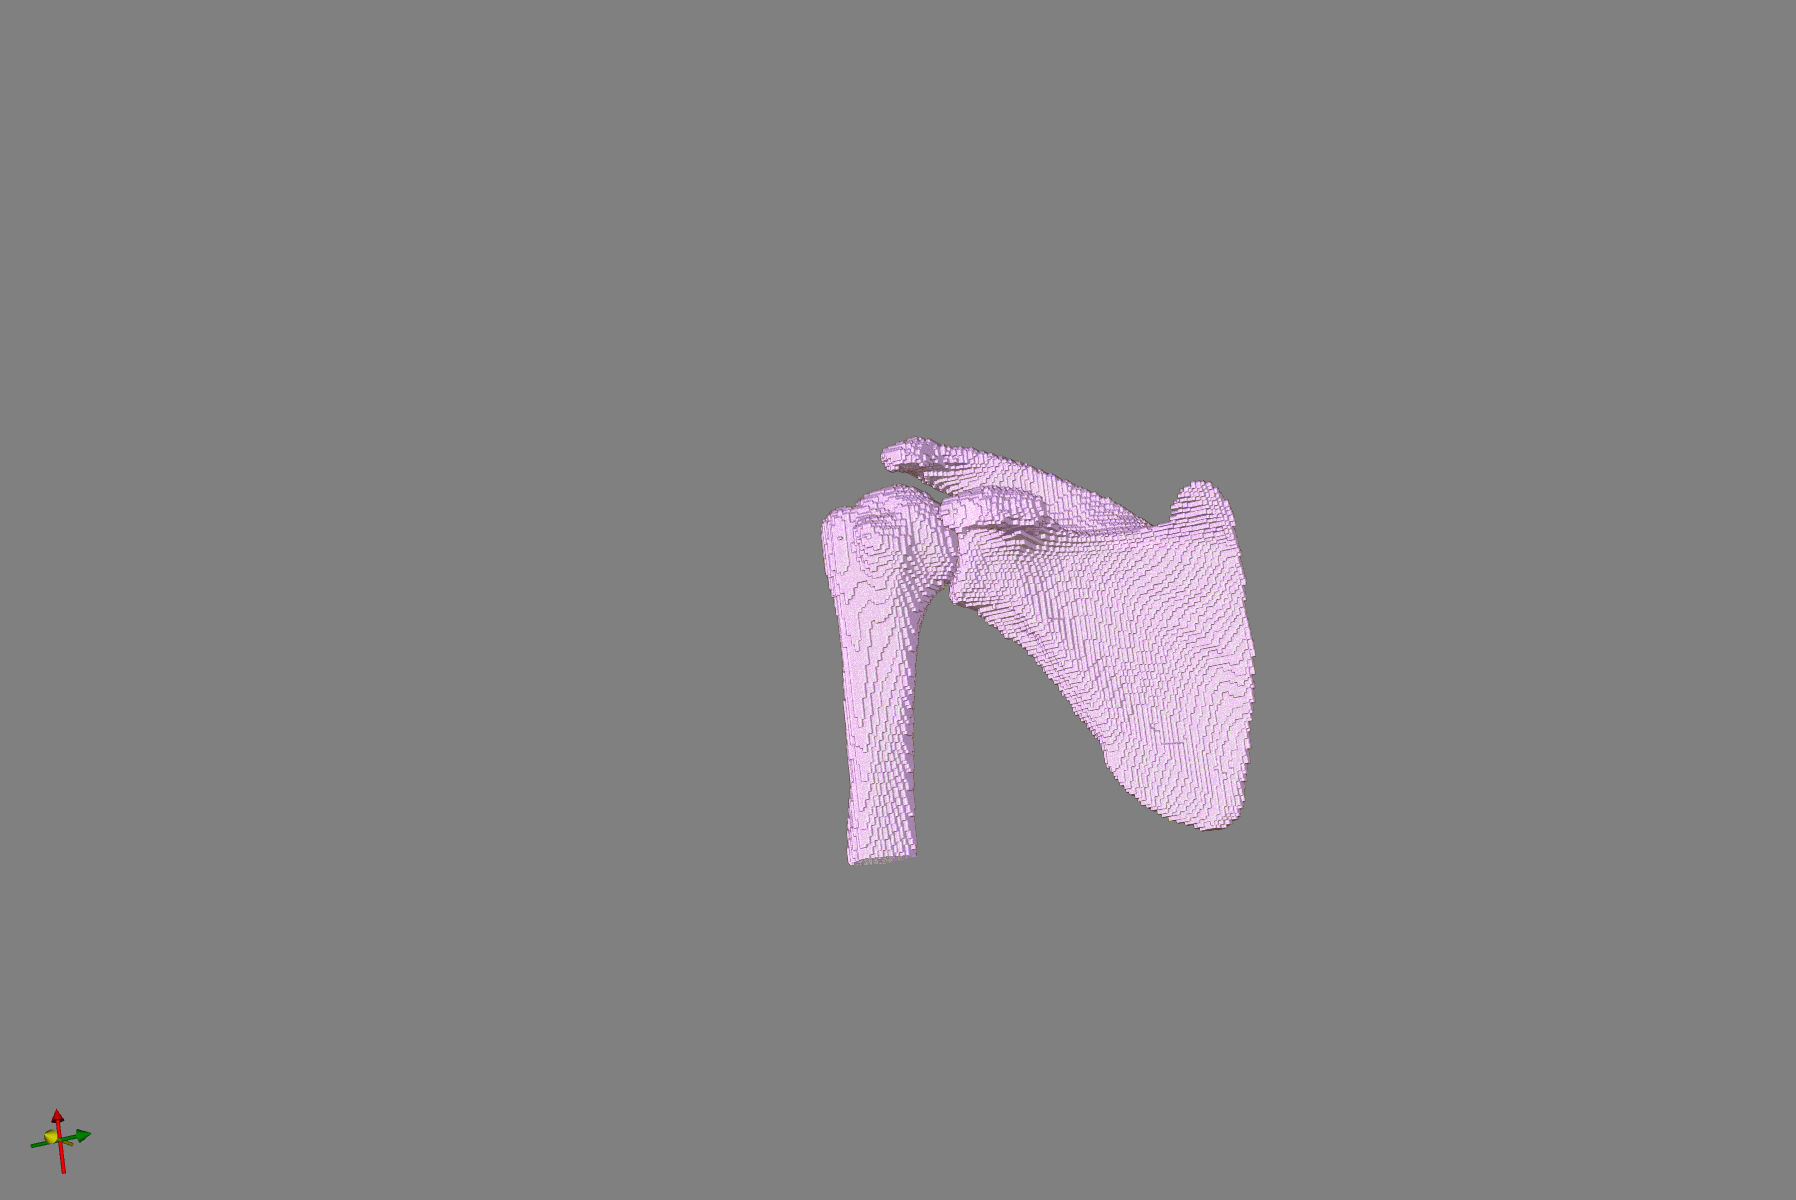

<IPython.core.display.Javascript object>

In [22]:
view(data)

In [26]:
data2 = np.asarray(nib.load("processing/4/shoulder_seg_res.nii").dataobj)


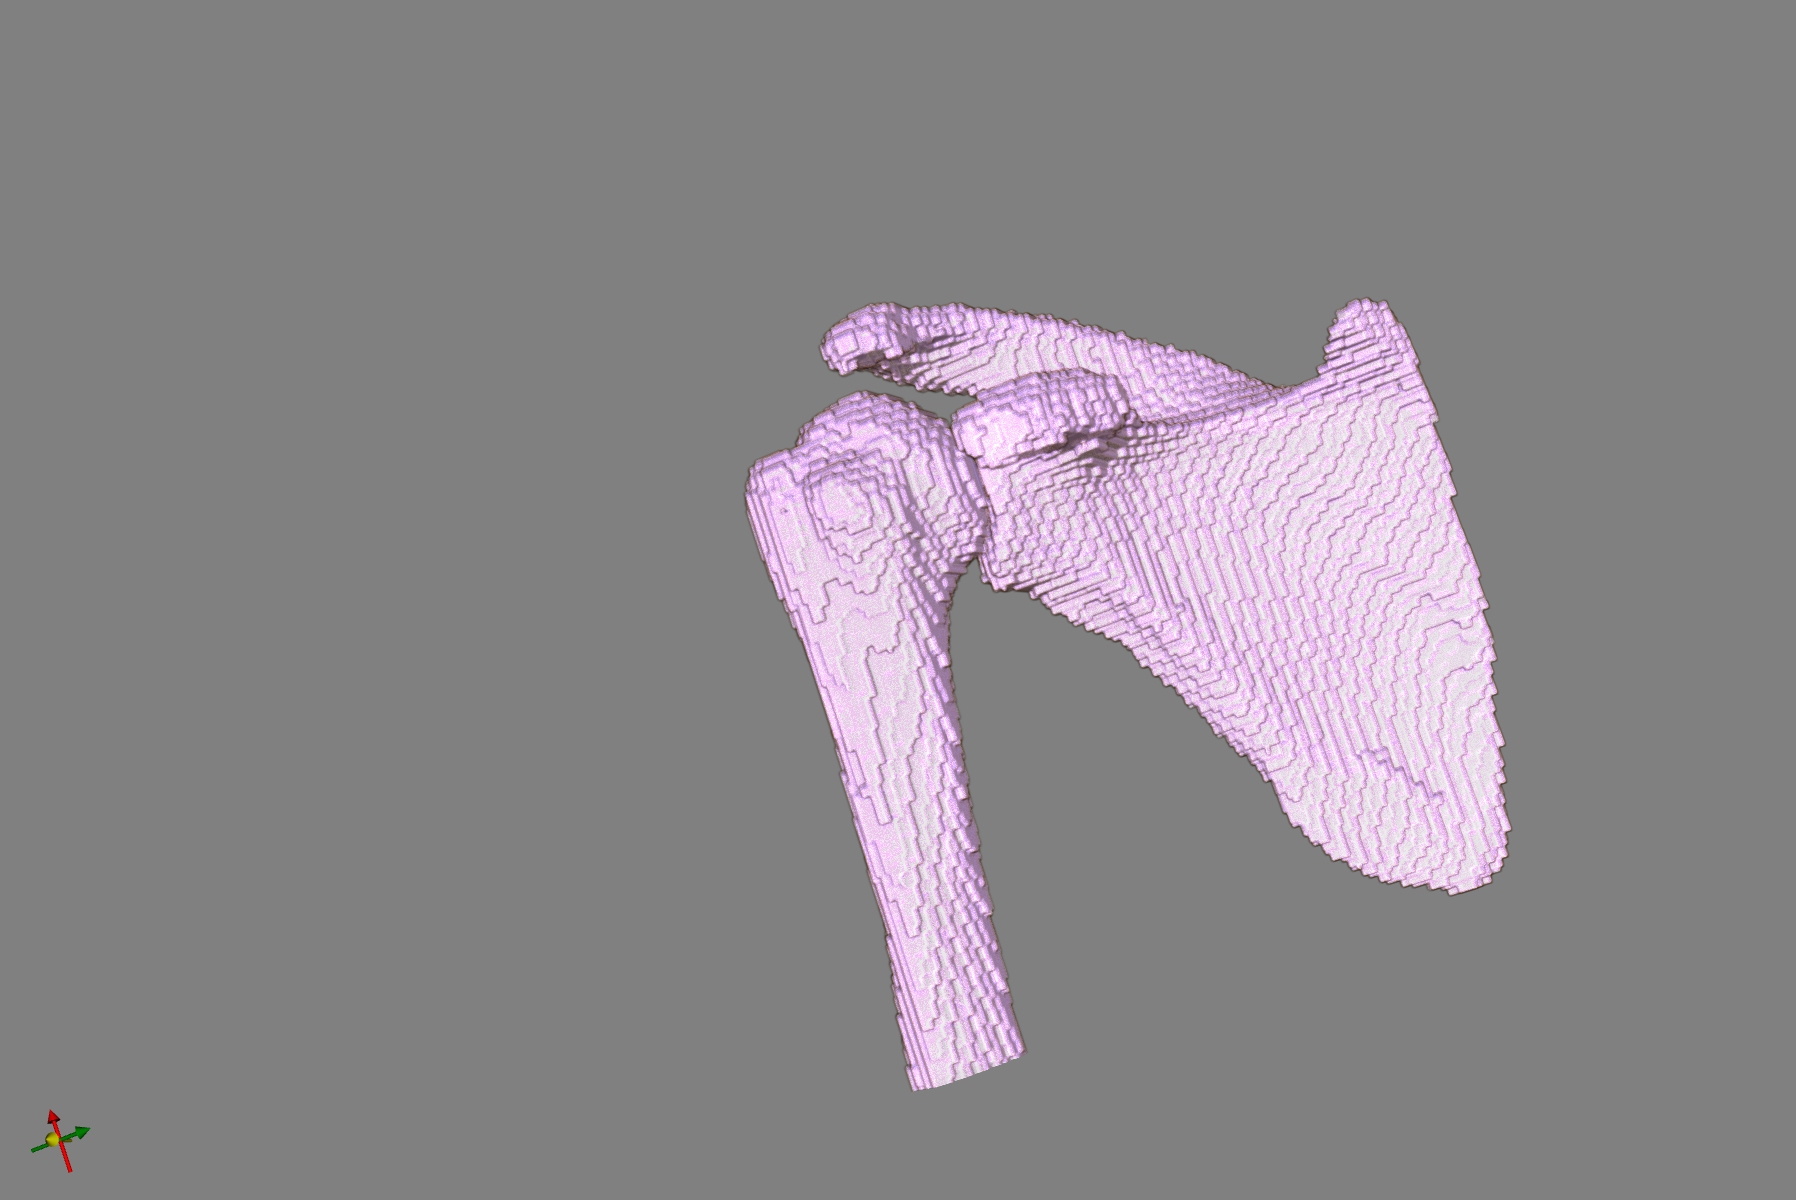
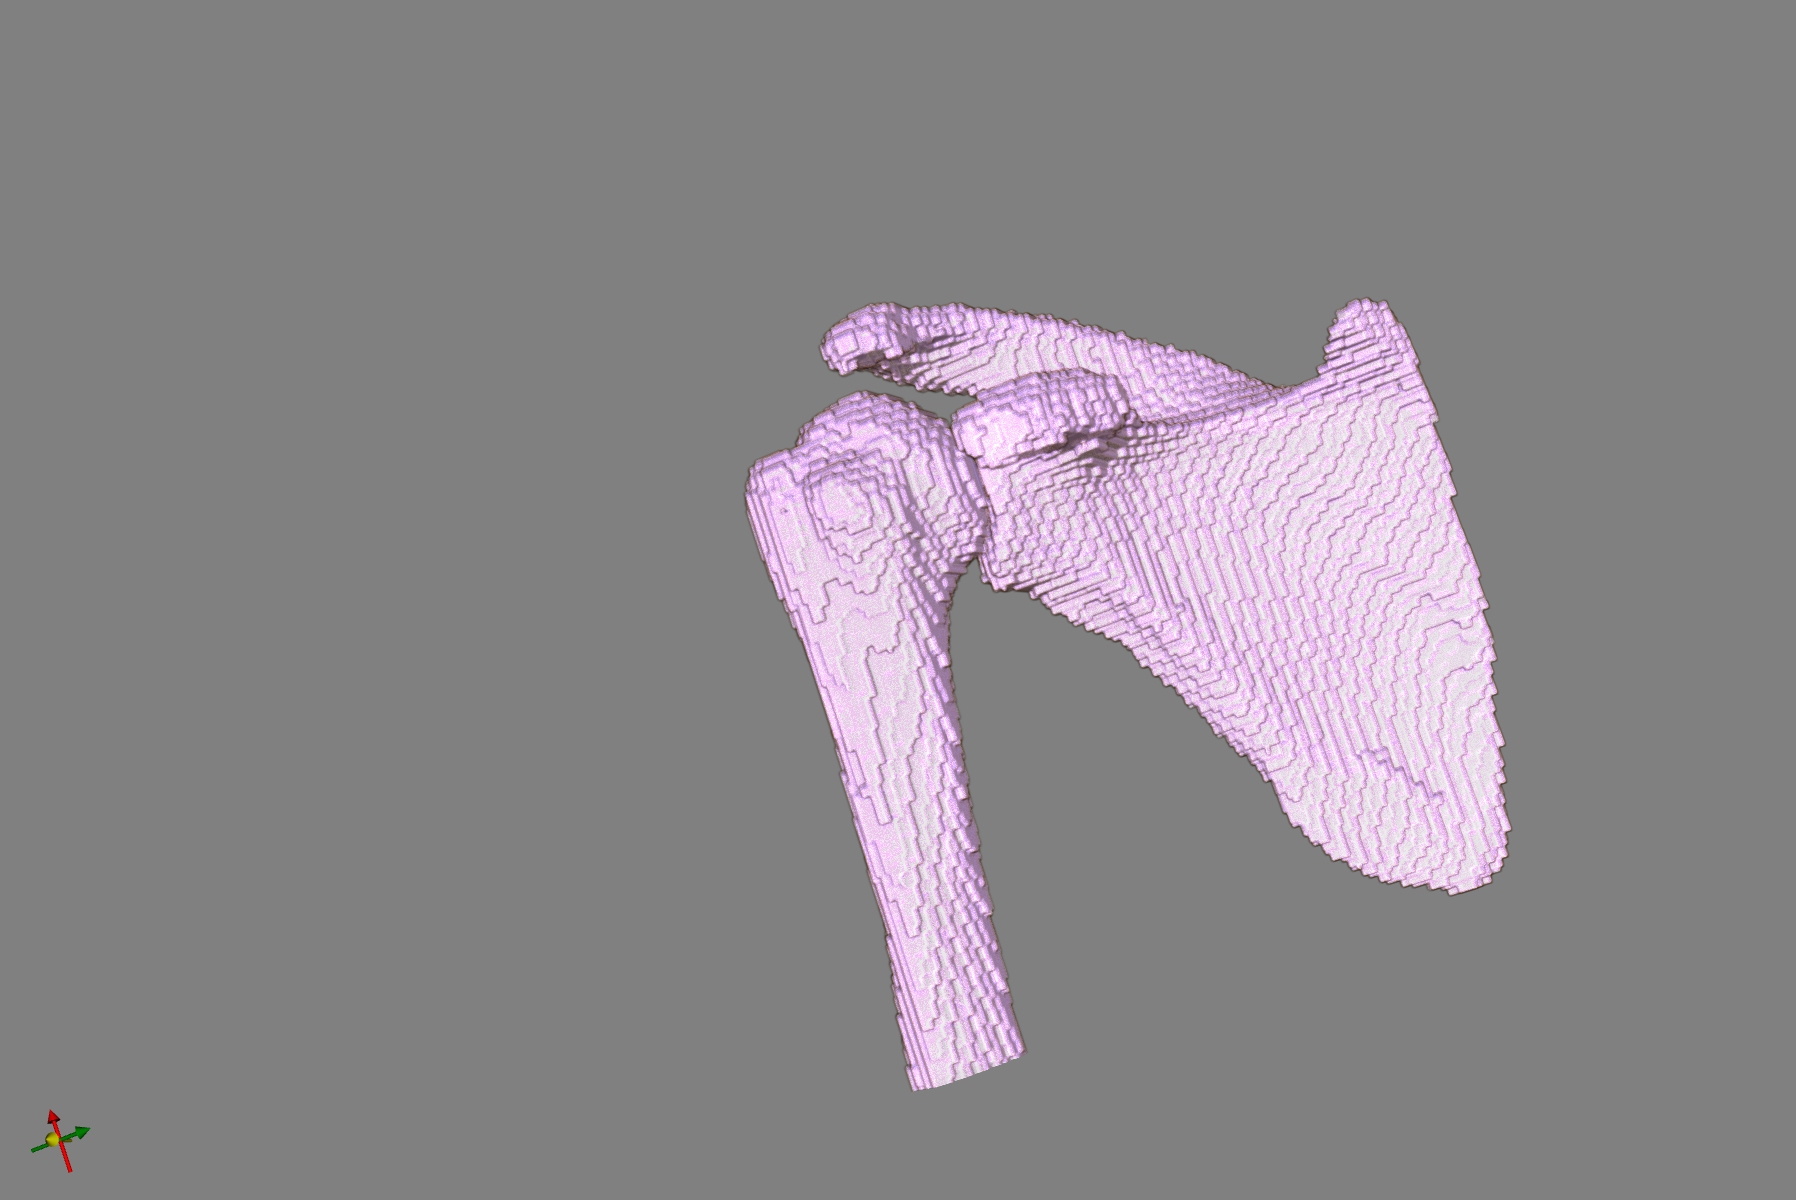

<IPython.core.display.Javascript object>

In [27]:
view(data2)